In [6]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL)

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev&mel_with_no_aug_(Train_+_Test)_Batch_Norm_focal"

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
#initializing ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [9]:
# Add additional layers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K

#function for focal loss
def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Compiling model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4)                   #configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                     #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [10]:
#function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculate ROC score

    # Calculate confusion matrix CHANGE THIS TO CM
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = cm[1,1] / (cm[1,1] + cm[0,1])
    specificity = cm[1,1] / (cm[1,1] + cm[1,0])

    total=sum(sum(cm))
    accuracy=(cm[0,0]+cm[1,1])/total
    print ('Accuracy : ', accuracy)

    report = classification_report(test_labels, predicted_labels) #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')  #Calculate Precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [12]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [12]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [13]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.7625 
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_no_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_1.hdf5
16/16 [==============================] - 500s 29s/step - loss: 0.1018 - accuracy: 0.7625 - val_loss: 0.0509 - val_accuracy: 0.8500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.7812 
Epoch 2: val_accuracy improved from 0.85000 to 0.87500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_no_aug_(Train

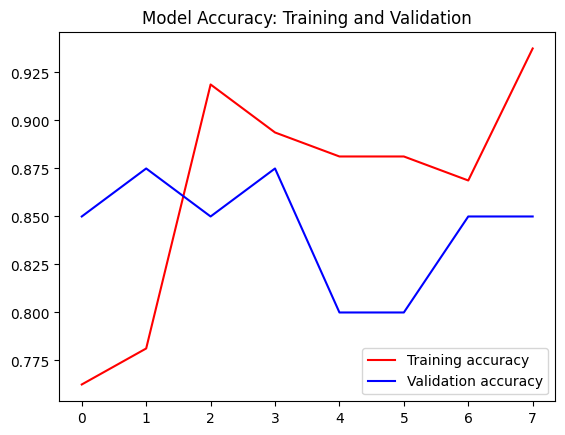

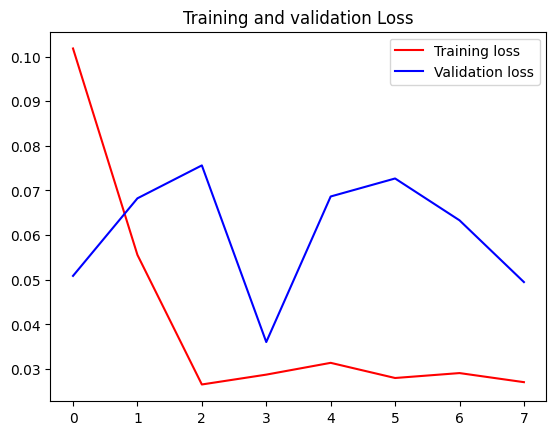

<Figure size 640x480 with 0 Axes>

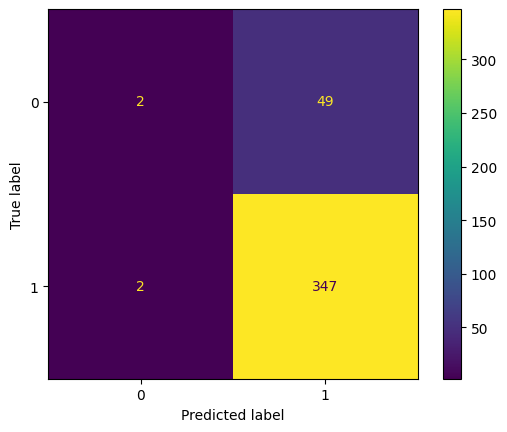


               precision    recall  f1-score   support

           0       0.50      0.04      0.07        51
           1       0.88      0.99      0.93       349

    accuracy                           0.87       400
   macro avg       0.69      0.52      0.50       400
weighted avg       0.83      0.87      0.82       400

Sensitivity: 0.994 Specificity: 0.039 Precision: 0.828 ROC_AUC_SCORE: 0.832



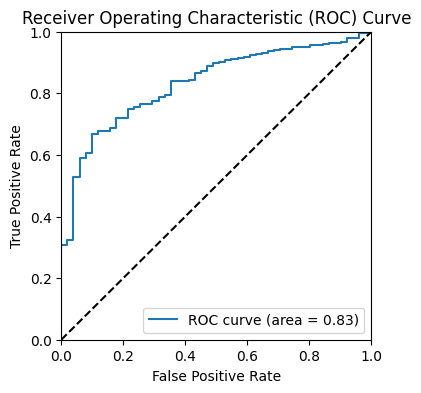

Validation complete...
Traning for Fold: 2
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.8500 
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_no_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_2.hdf5
16/16 [==============================] - 479s 28s/step - loss: 0.0458 - accuracy: 0.8500 - val_loss: 0.0311 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.8375 
Epoch 2: val_accuracy did not improve from 0.92500
16/16 [==============================] - 452s 28s/step - loss: 0.0521 - 

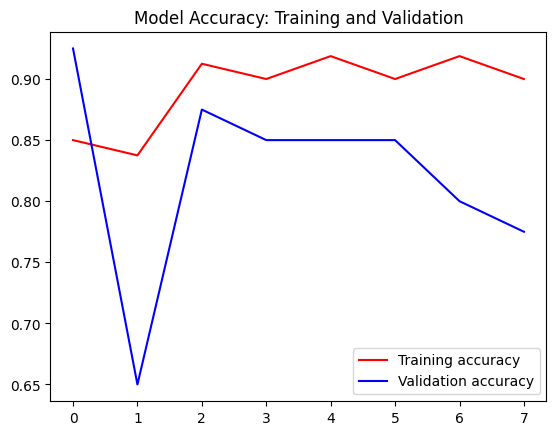

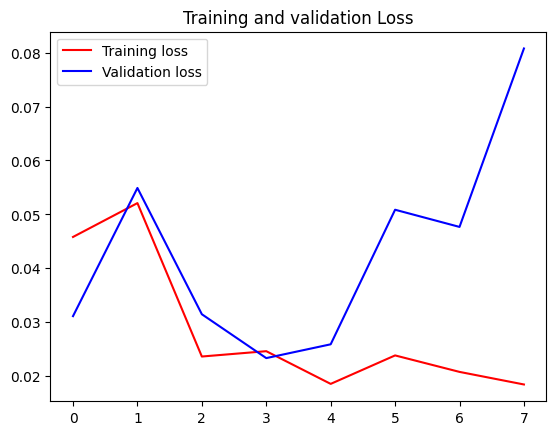

<Figure size 640x480 with 0 Axes>

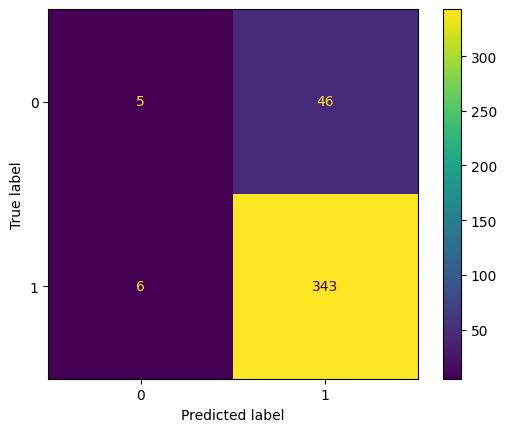


               precision    recall  f1-score   support

           0       0.45      0.10      0.16        51
           1       0.88      0.98      0.93       349

    accuracy                           0.87       400
   macro avg       0.67      0.54      0.55       400
weighted avg       0.83      0.87      0.83       400

Sensitivity: 0.983 Specificity: 0.098 Precision: 0.827 ROC_AUC_SCORE: 0.763



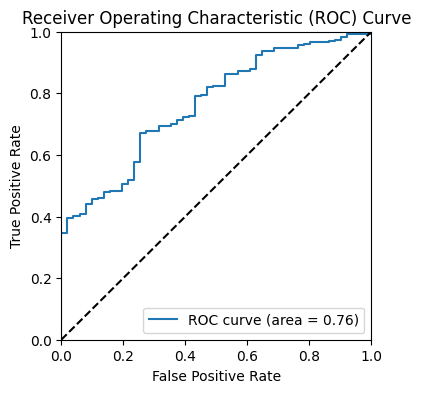

Validation complete...
Traning for Fold: 3
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.8813 
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_no_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_3.hdf5
16/16 [==============================] - 473s 27s/step - loss: 0.0351 - accuracy: 0.8813 - val_loss: 0.0417 - val_accuracy: 0.8750 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9312 
Epoch 2: val_accuracy did not improve from 0.87500
16/16 [==============================] - 444s 28s/step - loss: 0.0204 - 

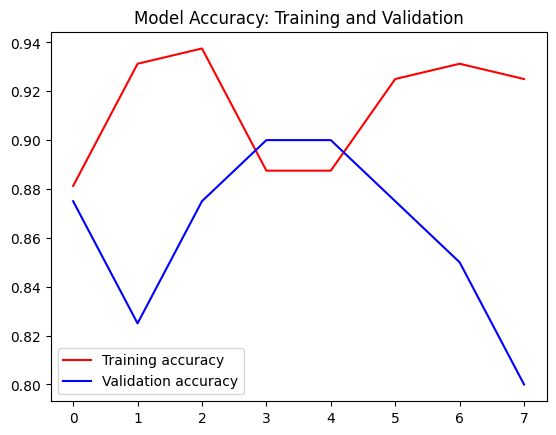

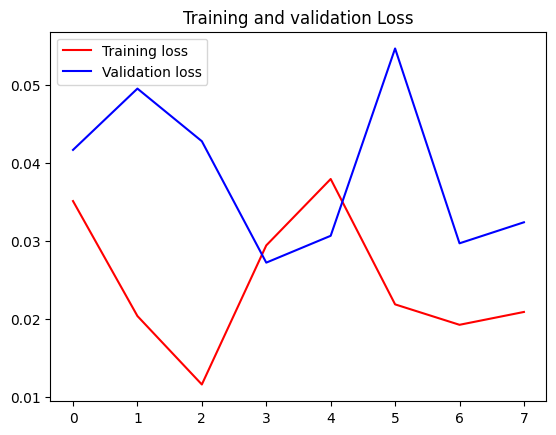

<Figure size 640x480 with 0 Axes>

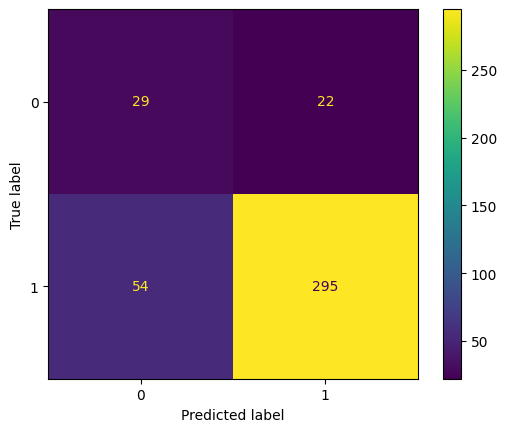


               precision    recall  f1-score   support

           0       0.35      0.57      0.43        51
           1       0.93      0.85      0.89       349

    accuracy                           0.81       400
   macro avg       0.64      0.71      0.66       400
weighted avg       0.86      0.81      0.83       400

Sensitivity: 0.845 Specificity: 0.569 Precision: 0.856 ROC_AUC_SCORE: 0.815



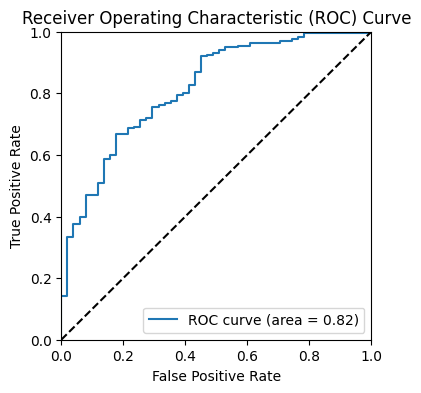

Validation complete...
Traning for Fold: 4
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9062 
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_no_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_4.hdf5
16/16 [==============================] - 487s 28s/step - loss: 0.0402 - accuracy: 0.9062 - val_loss: 0.0081 - val_accuracy: 0.9750 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9125 
Epoch 2: val_accuracy improved from 0.97500 to 1.00000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev

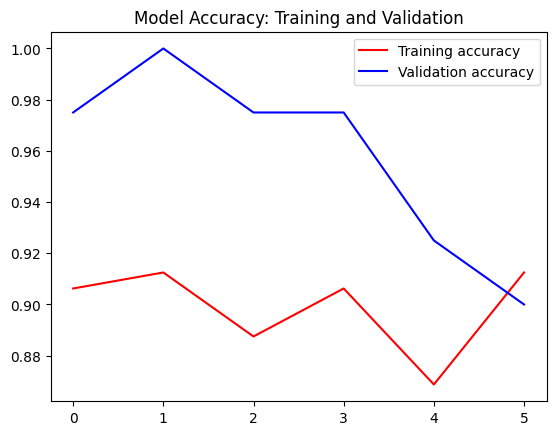

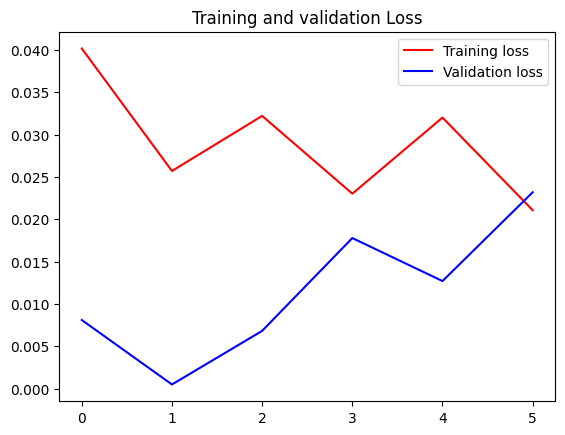

<Figure size 640x480 with 0 Axes>

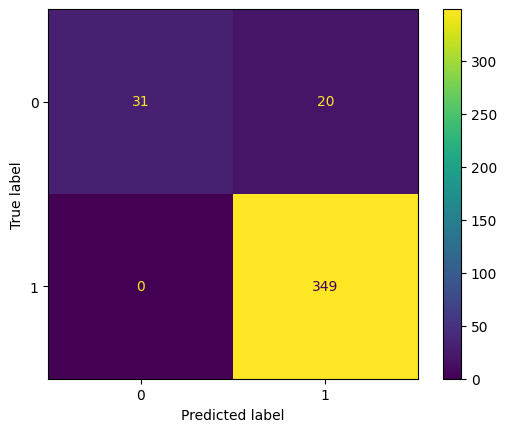


               precision    recall  f1-score   support

           0       1.00      0.61      0.76        51
           1       0.95      1.00      0.97       349

    accuracy                           0.95       400
   macro avg       0.97      0.80      0.86       400
weighted avg       0.95      0.95      0.94       400

Sensitivity: 1.0 Specificity: 0.608 Precision: 0.953 ROC_AUC_SCORE: 0.994



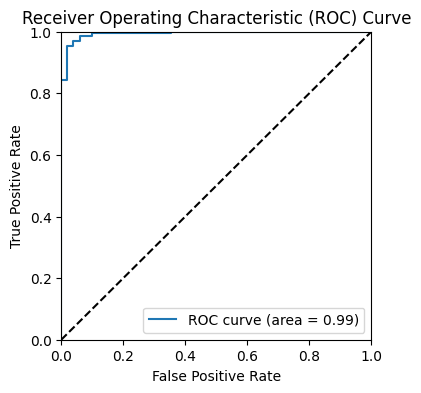

Validation complete...
Traning for Fold: 5
Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.7812 
Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_with_no_aug_(Train_+_Test)_Batch_Norm_focal/model_fold_5.hdf5
16/16 [==============================] - 474s 28s/step - loss: 0.0441 - accuracy: 0.7812 - val_loss: 0.0240 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.8938 
Epoch 2: val_accuracy improved from 0.92500 to 0.97500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev

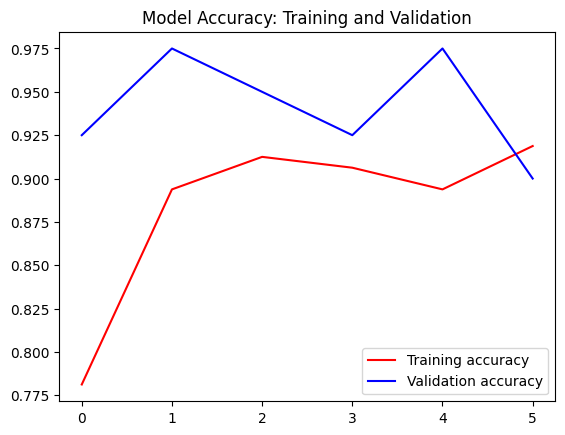

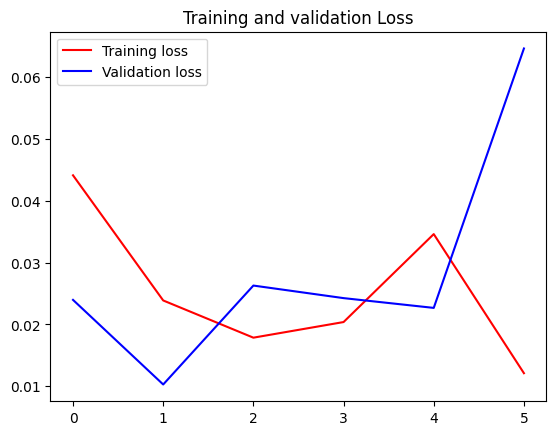

<Figure size 640x480 with 0 Axes>

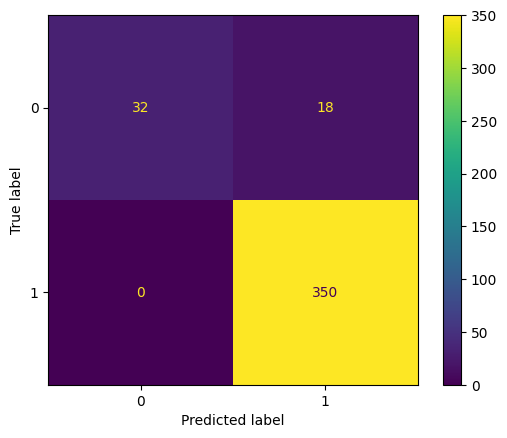


               precision    recall  f1-score   support

           0       1.00      0.64      0.78        50
           1       0.95      1.00      0.97       350

    accuracy                           0.95       400
   macro avg       0.98      0.82      0.88       400
weighted avg       0.96      0.95      0.95       400

Sensitivity: 1.0 Specificity: 0.64 Precision: 0.957 ROC_AUC_SCORE: 0.969



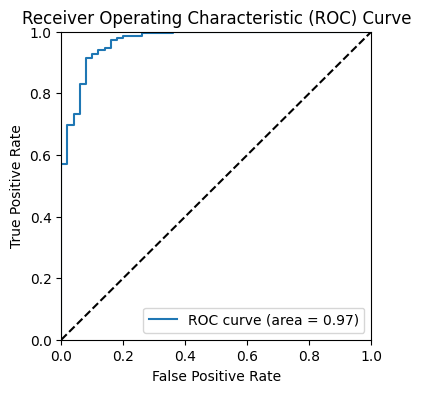

Validation complete...


In [15]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)

    # Evaluate the model on the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


In [23]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

Found 600 images belonging to 2 classes.


In [24]:
num_fold = 5

Test using model 1
600/600 [==============================] - 510s 851ms/step


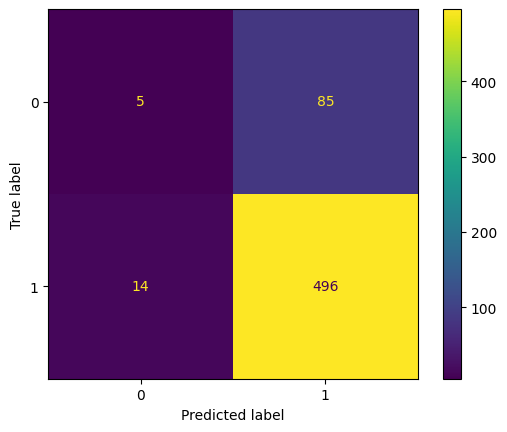

Accuracy :  0.835

               precision    recall  f1-score   support

           0       0.26      0.06      0.09        90
           1       0.85      0.97      0.91       510

    accuracy                           0.83       600
   macro avg       0.56      0.51      0.50       600
weighted avg       0.77      0.83      0.79       600

Sensitivity: 0.854 Specificity: 0.973 Precision: 0.765 ROC_AUC_SCORE: 0.667



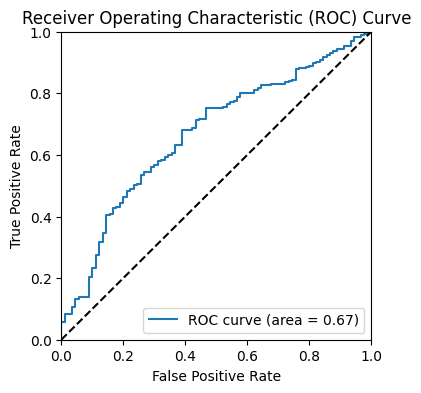

Testing Complete
Test using model 2
600/600 [==============================] - 505s 842ms/step


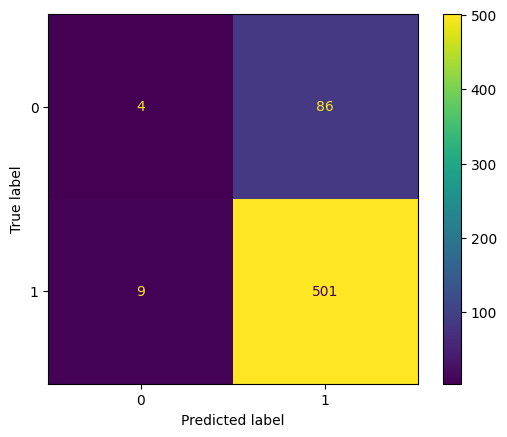

Accuracy :  0.8416666666666667

               precision    recall  f1-score   support

           0       0.31      0.04      0.08        90
           1       0.85      0.98      0.91       510

    accuracy                           0.84       600
   macro avg       0.58      0.51      0.50       600
weighted avg       0.77      0.84      0.79       600

Sensitivity: 0.853 Specificity: 0.982 Precision: 0.772 ROC_AUC_SCORE: 0.701



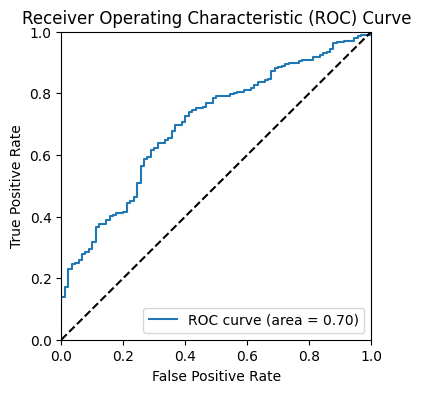

Testing Complete
Test using model 3
600/600 [==============================] - 517s 861ms/step


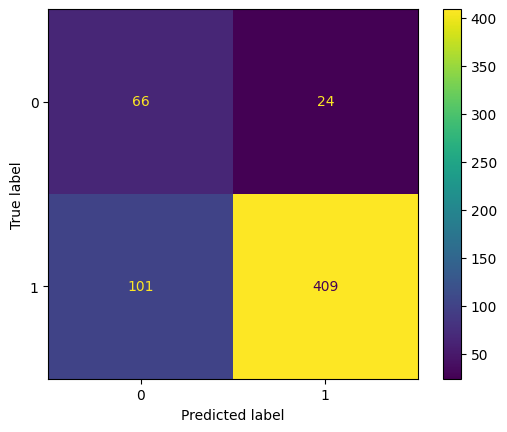

Accuracy :  0.7916666666666666

               precision    recall  f1-score   support

           0       0.40      0.73      0.51        90
           1       0.94      0.80      0.87       510

    accuracy                           0.79       600
   macro avg       0.67      0.77      0.69       600
weighted avg       0.86      0.79      0.81       600

Sensitivity: 0.945 Specificity: 0.802 Precision: 0.862 ROC_AUC_SCORE: 0.827



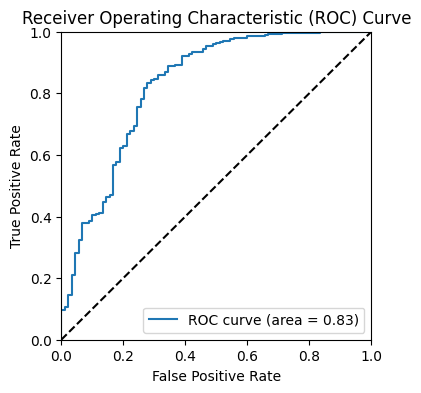

Testing Complete
Test using model 4
600/600 [==============================] - 503s 839ms/step


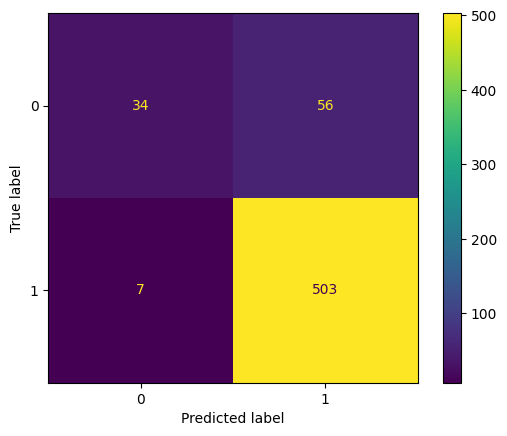

Accuracy :  0.895

               precision    recall  f1-score   support

           0       0.83      0.38      0.52        90
           1       0.90      0.99      0.94       510

    accuracy                           0.90       600
   macro avg       0.86      0.68      0.73       600
weighted avg       0.89      0.90      0.88       600

Sensitivity: 0.9 Specificity: 0.986 Precision: 0.889 ROC_AUC_SCORE: 0.868



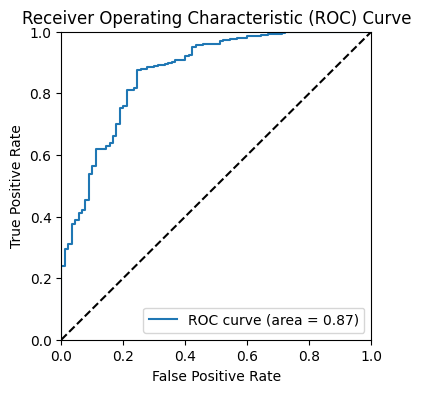

Testing Complete
Test using model 5
600/600 [==============================] - 511s 852ms/step


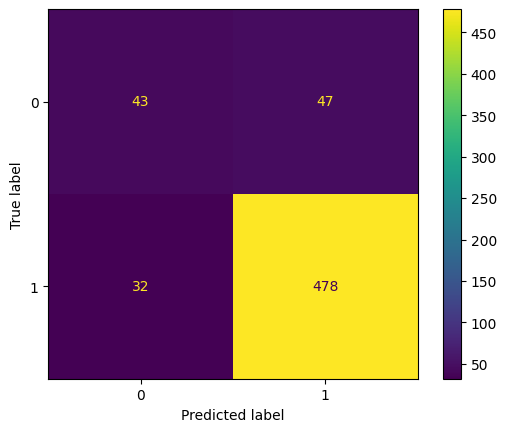

Accuracy :  0.8683333333333333

               precision    recall  f1-score   support

           0       0.57      0.48      0.52        90
           1       0.91      0.94      0.92       510

    accuracy                           0.87       600
   macro avg       0.74      0.71      0.72       600
weighted avg       0.86      0.87      0.86       600

Sensitivity: 0.91 Specificity: 0.937 Precision: 0.86 ROC_AUC_SCORE: 0.88



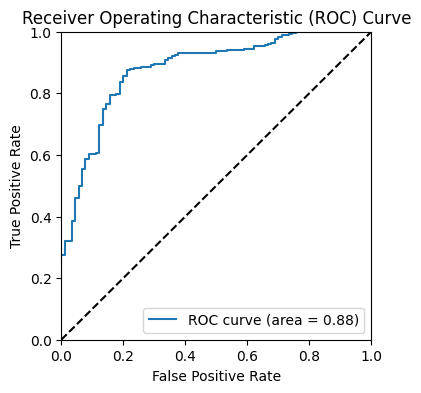

Testing Complete


In [25]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")